<h1 style="border:2px solid LightGreen; padding: 10px; text-align: center;">
    🌳 Melbourne Urban Forestry Analysis. 🌳
</h1>


### 📚 Import Libraries
Here, we import all necessary libraries required for our analysis on Tree Health in Melbourne.


In [12]:
#Imports
import ipywidgets as widgets
from IPython.display import display, clear_output
import requests
import pandas as pd
from IPython.display import HTML
from getpass import getpass
import json
from elasticsearch8 import Elasticsearch
from requests.auth import HTTPBasicAuth
from IPython.core.interactiveshell import InteractiveShell
import logging
import warnings
from requests.packages.urllib3.exceptions import InsecureRequestWarning
from flask import Flask, jsonify, request
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np




### 🔄 Fetching Data from the Database (RESTful Way)
This section is dedicated to retrieving data from our database for detailed analysis.

#### Fetching BoM data

In [15]:
# Fetch BoM data...
warnings.simplefilter('ignore')

global_df = pd.DataFrame()
current_offset = 0
total_hits = None 
es_password = getpass("Enter the Elasticsearch password: ")

def fetch_data_rest(es_host, es_port, es_username, es_password, size=1000, current_offset=0):
    url = f"https://{es_host}:{es_port}/melbourne_weather/_search"
    query = {
        "query": {
            "match_all": {}
        },
        "size": size,
        "from": current_offset
    }
    headers = {
    'Content-Type': 'application/json',
    'Accept': 'application/json'  # This line is to ensure the server knows what response format is acceptable
    }

    try:
        response = requests.post(url, headers=headers, json=query, auth=(es_username, es_password), verify=False)
        response.raise_for_status()
        data = response.json()
        hits = data['hits']['hits']
        total = data['hits']['total']['value']
        if hits:
            return pd.json_normalize([hit['_source'] for hit in hits]), len(hits), total
        else:
            return pd.DataFrame(), 0, total
    except requests.RequestException as e:
        logging.error(f"Failed to fetch data: {e}")
        return pd.DataFrame(), 0, 0

# Define the output area for button click responses
output = widgets.Output()
global_df = pd.DataFrame()
current_offset = 0

# Function to handle button click
def on_refresh_button_clicked(b):
    global current_offset, global_df, total_hits
    with output:
        if total_hits is None or current_offset < total_hits:
            df, num_hits, total_hits = fetch_data_rest('localhost', '9200', 'elastic', es_password)
            clear_output(wait=True)
            if not df.empty:
                global_df = pd.concat([global_df, df], ignore_index=True)
                display(df)
                current_offset += num_hits
                print(f"Fetched {num_hits} new records.")
            else:
                print("No more data to fetch or failed to fetch data.")
        else:
            clear_output(wait=True)
            print("No more data to fetch or reached the end of records.")

# Create the refresh button
button_style = {'description_width': 'initial', 'font_weight': 'bold'}
refresh_button = widgets.Button(
    description='🔄 Refresh Data',
    button_style='success',
    style=button_style,
    layout=widgets.Layout(width='auto', height='auto', align_self='center')
)

# Set the box style
box_layout = widgets.Layout(
    display='flex',
    flex_flow='column',
    align_items='center',
    width='100%',
    margin='10px'
)

# Function to display all data
def show_all_data(b):
    with output:
        clear_output(wait=True)
        display(global_df)

# Create a button to display all data
show_all_button = widgets.Button(
    description='Show All Data',
    button_style='info',
    style={'description_width': 'initial', 'font_weight': 'bold'},
    layout=widgets.Layout(width='auto', height='auto', align_self='center')
)

# Attach the function to the button
refresh_button.on_click(on_refresh_button_clicked)
show_all_button.on_click(show_all_data)

from IPython.display import display, HTML

# Custom CSS to force the output to wrap text and fit the container
# CSS for proper display
css = HTML("""
<style>
    .widget-output {
        width: 100% !important;
        overflow-x: auto;
        overflow-y: auto;
        min-height: 20px;
        max-height: 300px; 
    }
    .dataframe th, .dataframe td {
        white-space: nowrap;
        text-align: left;
        border: 1px solid #ddd;
        padding: 1px;
    }
    .dataframe {
        margin-bottom: 10px;
        width: auto !important;
        min-width: 100%; 
    }
</style>
""")

# Put the buttons inside a box to center them in the notebook
box = widgets.Box(children=[refresh_button, show_all_button], layout=box_layout)

# Display everything
display(box, output, css)

Box(children=(Button(button_style='success', description='🔄 Refresh Data', layout=Layout(align_self='center', …

Output()

#### Fetching Urban Trees data (External)

In [4]:
# Fetch Tree data...
warnings.simplefilter('ignore')


# Create Elasticsearch client
def fetch_data_for_sudo(es_host, es_port, es_username, es_password, es_index="urban_trees_ext_data"):
    url = f"https://{es_host}:{es_port}/{es_index}/_search?scroll=2m"  # Keep the search context alive for 2 minutes
    query = {
        "query": {
            "match_all": {}
        },
        "size": 1000  # Number of results per "page"
    }
    headers = {
        "Content-Type": "application/json"
    }

    # Initial search request
    initial_response = requests.post(url, headers=headers, data=json.dumps(query), auth=(es_username, es_password),verify=False)
    if initial_response.status_code != 200:
        logging.error(f"Failed to fetch data: HTTP {initial_response.status_code} - {initial_response.text}")
        return pd.DataFrame()

    # Process initial response
    initial_data = initial_response.json()
    all_hits = initial_data['hits']['hits']
    scroll_id = initial_data['_scroll_id']
    
    # Fetch remaining data with scrolling
    while True:
        scroll_url = f"https://{es_host}:{es_port}/_search/scroll"
        scroll_query = {
            "scroll": "2m",
            "scroll_id": scroll_id
        }
        response = requests.post(scroll_url, headers=headers, data=json.dumps(scroll_query), auth=(es_username, es_password), verify=False)
        if response.status_code != 200:
            logging.error(f"Failed to continue scrolling: HTTP {response.status_code} - {response.text}")
            break

        data = response.json()
        hits = data['hits']['hits']
        if not hits:
            break

        all_hits.extend(hits)
        scroll_id = data['_scroll_id']

    return pd.json_normalize([hit['_source'] for hit in all_hits])

if __name__ == "__main__":
    es_host = 'localhost'
    es_port = '9200'
    es_username = 'elastic'
    es_password = getpass("Enter the Elasticsearch password: ") # Use a secure method to handle passwords in production

    urban_trees_data = fetch_data_for_sudo(es_host, es_port, es_username, es_password)
    display(urban_trees_data)

com_id           common_name           scientific_name       genus  \
0      1440992         River red gum  Eucalyptus camaldulensis  Eucalyptus   
1      1286119         River red gum  Eucalyptus camaldulensis  Eucalyptus   
2      1439848  European nettle tree          Celtis australis      Celtis   
3      1584631          Swamp Sheoak           Casuarina obesa   Casuarina   
4      1286271         Golden Poplar      Populus x canadensis     Populus   
...        ...                   ...                       ...         ...   
76923  1526689               Red Box   Eucalyptus polyanthemos  Eucalyptus   
76924  1783637      Lightwood Wattle            Acacia implexa      Acacia   
76925  1023894          London Plane     Platanus x acerifolia    Platanus   
76926  1287085             Jacaranda     Jacaranda mimosifolia   Jacaranda   
76927  1783452  Lemon scented myrtle     Backhousia citriodora  Backhousia   

              family  diameter_breast_height year_planted date_planted  \
0          Myrtaceae                     NaN         2009   2009-12-14   
1          Myrtaceae                    80.0         2008   2008-07-16   
2        Cannabaceae                     4.0         2009   2009-09-08   
3      Casuarinaceae                     NaN         2015   2015-06-18   
4         Salicaceae                    35.0         2008   2008-12-18   
...              ...                     ...          ...          ...   
76923      Myrtaceae                     NaN         2013   2013-01-22   
76924       Fabaceae                     NaN         2020   2020-05-19   
76925    Platanaceae                    18.0         1899   1999-12-30   
76926   Bignoniaceae                     6.0         2008   2008-08-25   
76927      Myrtaceae                     NaN         2020   2020-12-05   

      age_description useful_life_expectency  ...  located_in  uploaddate  \
0                None                   None  ...        Park  2021-01-10   
1              Mature            31-60 years  ...        Park  2021-01-10   
2            Juvenile            31-60 years  ...      Street  2021-01-10   
3                None                   None  ...        Park  2021-01-10   
4         Semi-Mature            31-60 years  ...      Street  2021-01-10   
...               ...                    ...  ...         ...         ...   
76923            None                   None  ...        Park  2021-01-10   
76924            None                   None  ...        Park  2021-01-10   
76925     Semi-Mature            11-20 years  ...      Street  2021-01-10   
76926        Juvenile            11-20 years  ...      Street  2021-01-10   
76927            None                   None  ...        Park  2021-01-10   

        latitude   longitude    easting    northing  coordinatelocation.lon  \
0     -37.789043  144.947501  319271.37  5815606.69              144.947501   
1     -37.789890  144.925696  317353.24  5815470.25              144.925696   
2     -37.795228  144.919405  316812.46  5814865.65              144.919405   
3     -37.795179  144.952355  319713.76  5814935.15              144.952355   
4     -37.790418  144.927791  317538.99  5815415.81              144.927791   
...          ...         ...        ...         ...                     ...   
76923 -37.779684  144.962172  320540.70  5816673.41              144.962172   
76924 -37.781052  144.952380  319681.57  5816502.75              144.952380   
76925 -37.809249  144.965415  320897.72  5813398.98              144.965415   
76926 -37.836311  144.985137  322698.76  5810433.65              144.985137   
76927 -37.816217  144.980174  322213.84  5812653.90              144.980174   

       coordinatelocation.lat  geolocation.lon  geolocation.lat  
0                  -37.789043       144.947501       -37.789043  
1                  -37.789890       144.925696       -37.789890  
2                  -37.795228       144.919405       -37.795228  
3                  -37.795179       144.9523

#### Fetching Soil Trees data (External)

In [5]:
# Fetch Soil data...
warnings.simplefilter('ignore')


# Create Elasticsearch client
def fetch_data_for_sudo(es_host, es_port, es_username, es_password, es_index="soil_ext_data"):
    url = f"https://{es_host}:{es_port}/{es_index}/_search?scroll=2m"  # Keep the search context alive for 2 minutes
    query = {
        "query": {
            "match_all": {}
        },
        "size": 1000  # Number of results per "page"
    }
    headers = {
        "Content-Type": "application/json"
    }

    # Initial search request
    initial_response = requests.post(url, headers=headers, data=json.dumps(query), auth=(es_username, es_password),verify=False)
    if initial_response.status_code != 200:
        logging.error(f"Failed to fetch data: HTTP {initial_response.status_code} - {initial_response.text}")
        return pd.DataFrame()

    # Process initial response
    initial_data = initial_response.json()
    all_hits = initial_data['hits']['hits']
    scroll_id = initial_data['_scroll_id']
    
    # Fetch remaining data with scrolling
    while True:
        scroll_url = f"https://{es_host}:{es_port}/_search/scroll"
        scroll_query = {
            "scroll": "2m",
            "scroll_id": scroll_id
        }
        response = requests.post(scroll_url, headers=headers, data=json.dumps(scroll_query), auth=(es_username, es_password), verify=False)
        if response.status_code != 200:
            logging.error(f"Failed to continue scrolling: HTTP {response.status_code} - {response.text}")
            break

        data = response.json()
        hits = data['hits']['hits']
        if not hits:
            break

        all_hits.extend(hits)
        scroll_id = data['_scroll_id']

    return pd.json_normalize([hit['_source'] for hit in all_hits])

if __name__ == "__main__":
    es_host = 'localhost'
    es_port = '9200'
    es_username = 'elastic'
    es_password = getpass("Enter the Elasticsearch password: ") # Use a secure method to handle passwords in production

    soil_data = fetch_data_for_sudo(es_host, es_port, es_username, es_password)
    display(soil_data)

source     shape_area  \
0   Digitized from 1956 Geological Survey of Victo...  3087230.50876   
1   Digitized from 1956 Geological Survey of Victo...  3087230.50876   
2   Digitized from 1956 Geological Survey of Victo...  3087230.50876   
3   Digitized from 1956 Geological Survey of Victo...  3087230.50876   
4   Digitized from 1956 Geological Survey of Victo...  3087230.50876   
5   Digitized from 1956 Geological Survey of Victo...  3087230.50876   
6   Digitized from 1956 Geological Survey of Victo...  3087230.50876   
7   Digitized from 1956 Geological Survey of Victo...  3087230.50876   
8   Digitized from 1956 Geological Survey of Victo...  3087230.50876   
9   Digitized from 1956 Geological Survey of Victo...  3087230.50876   
10  Digitized from 1956 Geological Survey of Victo...  3087230.50876   
11  Digitized from 1956 Geological Survey of Victo...  3087230.50876   
12  Digitized from 1956 Geological Survey of Victo...  3087230.50876   
13  Digitized from 1956 Geological Survey of Victo...  3087230.50876   
14  Digitized from 1956 Geological Survey of Victo...  3087230.50876   
15  Digitized from 1956 Geological Survey of Victo...  3087230.50876   
16  Digitized from 1956 Geological Survey of Victo...  3087230.50876   
17  Digitized from 1956 Geological Survey of Victo...  3087230.50876   
18  Digitized from 1956 Geological Survey of Victo...  3087230.50876   
19  Digitized from 1956 Geological Survey of Victo...  3087230.50876   
20  Digitized from 1956 Geological Survey of Victo...  3087230.50876   
21  Digitized from 1956 Geological Survey of Victo...  3087230.50876   
22  Digitized from 1956 Geological Survey of Victo...  3087230.50876   
23  Digitized from 1956 Geological Survey of Victo...  3087230.50876   
24  Digitized from 1956 Geological Survey of Victo...  3087230.50876   
25  Digitized from 1956 Geological Survey of Victo...  3087230.50876   
26  Digitized from 1956 Geological Survey of Victo...  3087230.50876   

                                            soil             sub_base  \
0                                     Sandy Loam   Tertiary Sediments   
1                    Shallow Heavy Textured Clay  Basalt Old Volcanic   
2       Deep Stratified Sand/ Silt/ Clay/ Gravel        Alluvial Flat   
3       Deep Stratified Sand/ Silt/ Clay/ Gravel        Alluvial Flat   
4       Deep Stratified Sand/ Silt/ Clay/ Gravel        Alluvial Flat   
5                    Duplex - ClaySilt then Clay             Silurian   
6                    Duplex - ClaySilt then Clay             Silurian   
7                    Duplex - ClaySilt then Clay             Silurian   
8                                     Sandy Loam   Tertiary Sediments   
9                    Shallow Heavy Textured Clay  Basalt Old Volcanic   
10                                          Silt     Alluvial Terrace   
11  Medium to Heavy Textured Clay with some Sand        Alluvial Flat   
12                   Duplex - ClaySilt then Clay             Silurian   
13                   Duplex - ClaySilt then Clay             Silurian   
14                   Duplex - ClaySilt then Clay             Silurian   
15                   Duplex - ClaySilt then Clay             Silurian   
16                                    Sandy Loam   Tertiary Sediments   
17                                    Sandy Loam   Tertiary Sediments   
18                                    Sandy Loam   Tertiary Sediments   
19                                    Sandy Loam   Tertiary Sediments   
20                                    Sandy Loam   Tertiary Sediments   
21                   Shallow Heavy Textured Clay  Basalt New Volcanic   
22                   Shallow Heavy Textured Clay  Basalt New Volcanic   
23                   Shallow Heavy Textured Clay  Basalt Old Volcanic   
24                                          None                Water   
25      Deep Stratified Sand/ Silt/ Clay/ Gravel        Alluvial Flat   
26  Medium to Heavy Textured Clay with some Sand        All

#### Fetching Population Density Data (SUDO)

In [6]:
# Fetch Population data...
warnings.simplefilter('ignore')


# Create Elasticsearch client
def fetch_data_for_sudo(es_host, es_port, es_username, es_password, es_index="population_density_sudo"):
    url = f"https://{es_host}:{es_port}/{es_index}/_search?scroll=2m"  # Keep the search context alive for 2 minutes
    query = {
        "query": {
            "match_all": {}
        },
        "size": 1000  # Number of results per "page"
    }
    headers = {
        "Content-Type": "application/json"
    }

    # Initial search request
    initial_response = requests.post(url, headers=headers, data=json.dumps(query), auth=(es_username, es_password),verify=False)
    if initial_response.status_code != 200:
        logging.error(f"Failed to fetch data: HTTP {initial_response.status_code} - {initial_response.text}")
        return pd.DataFrame()

    # Process initial response
    initial_data = initial_response.json()
    all_hits = initial_data['hits']['hits']
    scroll_id = initial_data['_scroll_id']
    
    # Fetch remaining data with scrolling
    while True:
        scroll_url = f"https://{es_host}:{es_port}/_search/scroll"
        scroll_query = {
            "scroll": "2m",
            "scroll_id": scroll_id
        }
        response = requests.post(scroll_url, headers=headers, data=json.dumps(scroll_query), auth=(es_username, es_password), verify=False)
        if response.status_code != 200:
            logging.error(f"Failed to continue scrolling: HTTP {response.status_code} - {response.text}")
            break

        data = response.json()
        hits = data['hits']['hits']
        if not hits:
            break

        all_hits.extend(hits)
        scroll_id = data['_scroll_id']

    return pd.json_normalize([hit['_source'] for hit in all_hits])

if __name__ == "__main__":
    es_host = 'localhost'
    es_port = '9200'
    es_username = 'elastic'
    es_password = getpass("Enter the Elasticsearch password: ") # Use a secure method to handle passwords in production

    population_data = fetch_data_for_sudo(es_host, es_port, es_username, es_password)
    display(population_data)

id                sa2_name_2016  \
0    abs_regional_population_sa2_2001_2021.699              North Melbourne   
1    abs_regional_population_sa2_2001_2021.728                Hawthorn East   
2    abs_regional_population_sa2_2001_2021.700                    Parkville   
3    abs_regional_population_sa2_2001_2021.701           South Yarra - West   
4    abs_regional_population_sa2_2001_2021.748  Cheltenham - Highett (West)   
..                                         ...                          ...   
304  abs_regional_population_sa2_2001_2021.984                   Mornington   
305  abs_regional_population_sa2_2001_2021.985                  Mount Eliza   
306  abs_regional_population_sa2_2001_2021.986                 Mount Martha   
307  abs_regional_population_sa2_2001_2021.987                 Point Nepean   
308  abs_regional_population_sa2_2001_2021.989                   Somerville   

       gccsa_name_2016 state_name_2016  erp_2021         sa3_name_2016  \
0    Greater Melbourne        Victoria     26337        Melbourne City   
1    Greater Melbourne        Victoria     16724            Boroondara   
2    Greater Melbourne        Victoria      7964        Melbourne City   
3    Greater Melbourne        Victoria      6471        Melbourne City   
4    Greater Melbourne        Victoria     12534               Bayside   
..                 ...             ...       ...                   ...   
304  Greater Melbourne        Victoria     25976  Mornington Peninsula   
305  Greater Melbourne        Victoria     19064  Mornington Peninsula   
306  Greater Melbourne        Victoria     20088  Mornington Peninsula   
307  Greater Melbourne        Victoria     19241  Mornington Peninsula   
308  Greater Melbourne        Victoria     19449  Mornington Peninsula   

       area_km2  state_code_2016  erp_2011            sa4_name_2016  \
0      3.249200                2     16361        Melbourne - Inner   
1      3.824000                2     14417   Melbourne - Inner East   
2      4.049200                2      6551        Melbourne - Inner   
3      1.502700                2      6426        Melbourne - Inner   
4      5.319800                2     10544  Melbourne - Inner South   
..          ...              ...       ...                      ...   
304   21.092800                2     23224     Mornington Peninsula   
305   23.207701                2     17942     Mornington Peninsula   
306   30.209400                2     17581     Mornington Peninsula   
307   67.187500                2     16670     Mornington Peninsula   
308  117.353996                2     17907     Mornington Peninsula   

     pop_density_2021_people_per_km2 sa2_maincode_2016  sa4_code_2016  \
0                        8105.687500         206041123            206   
1                        4373.431152         207011152            207   
2                        1966.808350         206041124            206   
3                        4306.249023         206041125            206   
4                        2356.103516         208011171            208   
..                               ...               ...            ...   
304                      1231.510254         214021380            214   
305                       821.451477         214021381            214   
306                       664.958618         214021382            214   
307                       286.377686         214021383            214   
308                       165.729294         214021385            214   

     primaryindex  erp_2001 gccsa_code_2016  sa3_code_2016 geometry.type  \
0             699     11639           2GMEL          20604  MultiPolygon   
1             728     12912           2GMEL          20701  MultiPolygon   
2             700      5332           2GMEL          20604  MultiPolygon   
3             701      5317           2GMEL          20604  MultiPolygon   
4             748      9657           2GMEL          20801  MultiPolygon   
..            ...   

### 🔍 Exploratory Analysis for all Fetched Data
In this section, we delve into our data to uncover patterns, trends, and anomalies.

In [7]:
# Display information about weather data
print(global_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame
None


In [13]:
#Cleaning Weather data.
global_df['current_date_time'] = pd.to_datetime(global_df['current_date_time'], errors='coerce')
    
# Fill missing numeric data with mean or interpolate
numeric_cols = ['latitude', 'longitude', 'temp', 'app_temp', 'dew_point', 'rel_hum', 'delta_t', 'wind_spd', 'wind_gust', 'press_msl', 'low_temp', 'high_temp','rain']
for col in numeric_cols:
    global_df[col] = pd.to_numeric(global_df[col], errors='coerce')
    global_df[col] = global_df[col].fillna(global_df[col].interpolate())  # or use global_df[col].interpolate()

    # Ensure correct data types
global_df['station'] = global_df['station'].astype(str)
global_df['wind_dir'] = global_df['wind_dir'].astype(str)
global_df['high_wind_gust_dir'] = global_df['high_wind_gust_dir'].astype(str)
global_df['high_wind_gust_time'] = pd.to_datetime(global_df['high_wind_gust_time'], errors='coerce')
    
global_df = global_df[global_df['station'] != 'nan']

KeyError: 'current_date_time'

Data Cleaning - Suburb boundaries

In [ ]:
%pip install shapely
%pip install contextily
%pip install geopandas
%pip install plottable

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [38]:
## Importing Libraries
import math, os
import numpy as np
import pandas as pd
import seaborn as sns 
import contextily as cx
import geopandas as gpd

import matplotlib
from matplotlib import pyplot as plt
from shapely.geometry import Polygon
from shapely.ops import unary_union
from plottable import Table
from plottable.formatters import decimal_to_percent
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Circle

from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [22]:
## The analysis in this project focuses on the City of Melbourne,
## thus, the CRS EPSG 7855 is choosen to transform all geographical data consistently
out_crs = 7855

## The City of Melbourne's municipal boundary polygon
## Source from:
## https://discover.data.vic.gov.au/dataset/municipal-boundary
municipal_gdf = gpd.read_file("Polygon_data/city_of_melbourne/municipal-boundary.shp")
municipal_gdf = municipal_gdf.to_crs(out_crs)

## The City of Melbourne's suburb boundaries
## Source from: 
## https://data.melbourne.vic.gov.au/explore/dataset/small-areas-for-census-of-land-use-and-employment-clue/information/
suburb_gdf = gpd.read_file("Polygon_data/census_suburb/small-areas-for-census-of-land-use-and-employment-clue.shp")
suburb_gdf = suburb_gdf.to_crs(out_crs)
suburb_gdf = gpd.clip(suburb_gdf, municipal_gdf)
suburb_gdf = suburb_gdf.drop(columns = ['shape_len'])
suburb_gdf.rename(columns={'featurenam': 'Suburb Name', 'shape_area': 'Area (m^2)'}, inplace=True)

In [23]:
suburb_gdf

Suburb Name     Area (m^2)  \
6                    South Yarra  1057773.39715   
3          Melbourne (Remainder)  2668300.95898   
5                      Southbank  1596010.33174   
7                 East Melbourne  1909072.65637   
2                Melbourne (CBD)  2485904.89194   
10                       Carlton  2724820.83121   
12                Port Melbourne  5470092.78821   
9                      Docklands  2856028.73238   
8    West Melbourne (Industrial)  5917883.21599   
1   West Melbourne (Residential)  860054.675679   
11               North Melbourne  2408377.21789   
0                     Kensington  3808797.49677   
4                      Parkville   4050997.2362   

                                             geometry  
6   POLYGON ((322619.656 5809407.034, 322294.651 5...  
3   POLYGON ((322650.671 5808839.566, 322336.207 5...  
5   POLYGON ((320282.822 5811963.889, 320300.662 5...  
7   POLYGON ((321860.347 5813528.984, 323177.833 5...  
2   POLYGON ((319893.512 5813019.873, 320111.716 5...  
10  POLYGON ((321410.442 5813598.172, 321379.389 5...  
12  POLYGON ((316056.169 5812009.129, 316447.801 5...  
9   POLYGON ((319719.658 5812826.857, 319761.152 5...  
8   POLYGON ((316888.804 5812209.758, 316663.769 5...  
1   POLYGON ((319579.875 5812900.191, 319486.197 5...  
11  POLYGON ((320178.277 5814208.520, 320273.382 5...  
0   POLYGON ((318318.308 5815533.028, 318313.110 5...  
4   POLYGON ((318612.614 5815797.521, 318603.428 5...

In [24]:
## Data cleaning - Polygon data
## aims to construct gazetted suburb or postcode boundaries in the City of Melbounre
## based on https://www.melbourne.vic.gov.au/sitecollectiondocuments/suburb-map-boundary-city-of-melbourne.pdf


## Constructing Melbourne (postcode 3000) boundary
Melbourne_Remainder = suburb_gdf[suburb_gdf['Suburb Name'] == "Melbourne (Remainder)"].geometry
Melbourne_CBD = suburb_gdf[suburb_gdf['Suburb Name'] == "Melbourne (CBD)"].geometry

Melbourne = [Melbourne_Remainder, Melbourne_CBD]
Melbourne = unary_union(Melbourne)

suburb_gdf = suburb_gdf.drop(suburb_gdf[suburb_gdf['Suburb Name'] == 'Melbourne (Remainder)'].index)
suburb_gdf = suburb_gdf.drop(suburb_gdf[suburb_gdf['Suburb Name'] == 'Melbourne (CBD)'].index)

Melbourne_gdf = gpd.GeoDataFrame({'Suburb Name': ['Melbourne'], 'Area (m^2)': [Melbourne.area]}, geometry=[Melbourne], crs='EPSG:7855')
suburb_gdf = pd.concat([suburb_gdf, Melbourne_gdf], ignore_index=True)


## Constructing West Melbourne (postcode 3003) boundary
West_Melbourne_Industrial = suburb_gdf[suburb_gdf['Suburb Name'] == "West Melbourne (Industrial)"].geometry
West_Melbourne_Residential = suburb_gdf[suburb_gdf['Suburb Name'] == "West Melbourne (Residential)"].geometry

West_Melbourne  = [West_Melbourne_Industrial,West_Melbourne_Residential]
West_Melbourne = unary_union(West_Melbourne)

suburb_gdf = suburb_gdf.drop(suburb_gdf[suburb_gdf['Suburb Name'] == 'West Melbourne (Industrial)'].index)
suburb_gdf = suburb_gdf.drop(suburb_gdf[suburb_gdf['Suburb Name'] == 'West Melbourne (Residential)'].index)

West_Melbourne_gdf = gpd.GeoDataFrame({'Suburb Name': ['West Melbourne'], 'Area (m^2)': [West_Melbourne.area]}, geometry=[West_Melbourne], crs='EPSG:7855')
suburb_gdf = pd.concat([suburb_gdf, West_Melbourne_gdf], ignore_index=True)


## Constructung Kensington (postcode 3031) and flemington (postcode 3031), they have same postcode in the City of Melbourne area
suburb_gdf = suburb_gdf.drop(suburb_gdf[suburb_gdf['Suburb Name'] == 'Kensington'].index)

flemington_gdf = gpd.read_file("Polygon_data/flemington/flemington.shp")
flemington_gdf = gpd.clip(flemington_gdf, municipal_gdf)
## hard coding to clip some redundant lines
target_area = Polygon([(315000, 5814750), (315000, 5816750), (317250, 5816750), (317250, 5814750), (315000, 5814750)])
flemington_gdf = gpd.clip(flemington_gdf, target_area)

kensington_gdf = gpd.read_file("Polygon_data/kensington/kensington.shp")
kensington_gdf = gpd.clip(kensington_gdf, municipal_gdf)

Flemington_gdf = gpd.GeoDataFrame({'Suburb Name': ['Flemington'], 'Area (m^2)': [flemington_gdf.area[0]]}, geometry=[flemington_gdf.geometry[0]], crs='EPSG:7855')
suburb_gdf = pd.concat([suburb_gdf, Flemington_gdf], ignore_index=True)

Kensington_gdf = gpd.GeoDataFrame({'Suburb Name': ['Kensington'], 'Area (m^2)': [kensington_gdf.area[0]]}, geometry=[kensington_gdf.geometry[0]], crs='EPSG:7855')
suburb_gdf = pd.concat([suburb_gdf, Kensington_gdf], ignore_index=True)


## Constructing Carlton (postcode 3053) and North Carlton (postcode 3054)
suburb_gdf = suburb_gdf.drop(suburb_gdf[suburb_gdf['Suburb Name'] == 'Carlton'].index)

carlton_gdf = gpd.read_file("Polygon_data/carlton/carlton.shp")
north_carlton_gdf = gpd.read_file("Polygon_data/north_carlton/north_carlton.shp")
north_carlton_gdf = gpd.clip(north_carlton_gdf, municipal_gdf)

Carlton_gdf = gpd.GeoDataFrame({'Suburb Name': ['Carlton'], 'Area (m^2)': [carlton_gdf.area[0]]}, geometry=[carlton_gdf.geometry[0]], crs='EPSG:7855')
suburb_gdf = pd.concat([suburb_gdf, Carlton_gdf], ignore_index=True)

North_carlton_gdf = gpd.GeoDataFrame({'Suburb Name': ['North Carlton'], 'Area (m^2)': [north_carlton_gdf.area[0]]}, geometry=[north_carlton_gdf.geometry[0]], crs='EPSG:7855')
suburb_gdf = pd.concat([suburb_gdf, North_carlton_gdf], ignore_index=True)

## Constructing South Wharf (postcode 3005)
south_wharf_gdf = gpd.read_file("Polygon_data/south_wharf/south_wharf.shp")
South_wharf_gdf = gpd.GeoDataFrame({'Suburb Name': ['South Wharf'], 'Area (m^2)': [south_wharf_gdf.area[0]]}, geometry=[south_wharf_gdf.geometry[0]], crs='EPSG:7855')
suburb_gdf = pd.concat([suburb_gdf, South_wharf_gdf], ignore_index=True)

## Constructing southbank (postcode 3006)
suburb_gdf = suburb_gdf.drop(suburb_gdf[suburb_gdf['Suburb Name'] == 'Southbank'].index)
southbank_gdf = gpd.read_file("Polygon_data/southbank/southbank.shp")
southbank_gdf = gpd.clip(southbank_gdf, municipal_gdf)

## hard coding to clip some redundant lines
target_area = Polygon([(319800, 5810800), (319800, 5812400), (321500, 5812400), (321500, 5810800), (319800, 5810800)])
southbank_gdf = gpd.clip(southbank_gdf, target_area)
Southbank_gdf = gpd.GeoDataFrame({'Suburb Name': ['Southbank'], 'Area (m^2)': [southbank_gdf.area[0]]}, geometry=[southbank_gdf.geometry[0]], crs='EPSG:7855')
suburb_gdf = pd.concat([suburb_gdf, Southbank_gdf], ignore_index=True)

## formatting the geographical dataframe
suburb_gdf['Area (m^2)'] = round(suburb_gdf['Area (m^2)'].astype(float) / 10 ** 6, 2)
suburb_gdf.rename(columns={'Area (m^2)': 'Area (km^2)'}, inplace=True)
suburb_gdf.insert(1, 'Postcode', [3141, 3002, 3207, 3008, 3051, 3052, 3000, 3003, 3031, 3031, 3053, 3054, 3005, 3006])

suburb_gdf.at[0, 'Suburb Name'] = 'South Yarra - West' 
suburb_gdf.at[8, 'Suburb Name'] = 'Flemington Racecourse'
suburb_gdf.at[9, 'Suburb Name'] = 'Kensington (Vic.)'
suburb_gdf.at[11, 'Suburb Name'] = 'Carlton North - Princes Hill'


In [25]:
suburb_gdf

Suburb Name  Postcode  Area (km^2)  \
0             South Yarra - West      3141         1.06   
1                 East Melbourne      3002         1.91   
2                 Port Melbourne      3207         5.47   
3                      Docklands      3008         2.86   
4                North Melbourne      3051         2.41   
5                      Parkville      3052         4.05   
6                      Melbourne      3000         5.15   
7                 West Melbourne      3003         6.78   
8          Flemington Racecourse      3031         1.70   
9              Kensington (Vic.)      3031         2.13   
10                       Carlton      3053         1.75   
11  Carlton North - Princes Hill      3054         0.91   
12                   South Wharf      3005         0.26   
13                     Southbank      3006         1.31   

                                             geometry  
0   POLYGON ((322619.656 5809407.034, 322294.651 5...  
1   POLYGON ((321860.347 5813528.984, 323177.833 5...  
2   POLYGON ((316056.169 5812009.129, 316447.801 5...  
3   POLYGON ((319719.658 5812826.857, 319761.152 5...  
4   POLYGON ((320178.277 5814208.520, 320273.382 5...  
5   POLYGON ((318612.614 5815797.521, 318603.428 5...  
6   POLYGON ((322336.207 5808883.294, 322258.102 5...  
7   POLYGON ((316663.769 5812156.304, 316447.801 5...  
8   POLYGON ((317097.521 5815560.242, 317106.417 5...  
9   POLYGON ((316853.535 5814487.189, 316713.200 5...  
10  POLYGON ((321639.944 5814098.047, 321580.474 5...  
11  POLYGON ((320370.756 5815419.148, 320358.503 5...  
12  POLYGON ((319973.211 5811460.455, 319939.465 5...  
13  POLYGON ((319939.465 5811432.231, 319973.211 5...

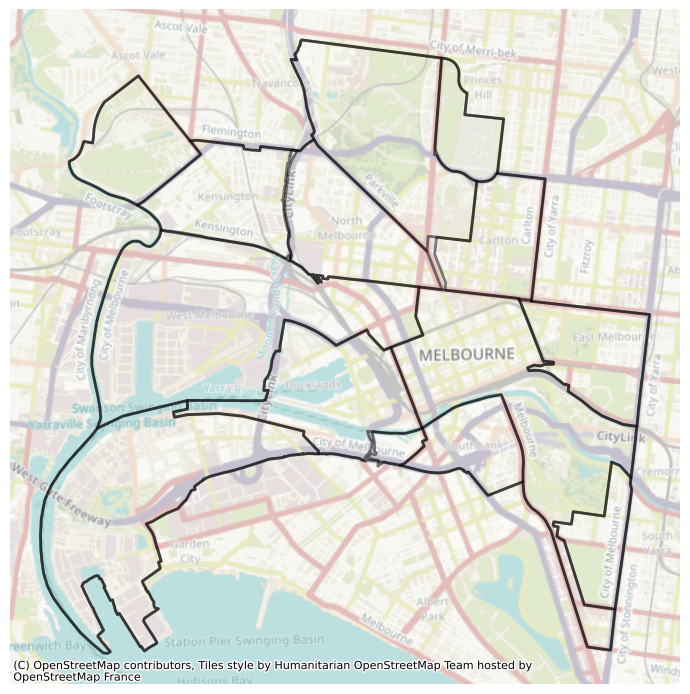

In [26]:
## Plotting suburb boundaries to the City of Melbourne's map
fig, ax = plt.subplots(figsize=(7, 9))
ax.axis('off')

municipal_gdf.plot(ax=ax, 
                 facecolor = 'none', 
                 edgecolor='black', 
                 linewidth=2, 
                 alpha=0.5)

suburb_gdf.plot(ax=ax, 
                 facecolor = 'none', 
                 edgecolor='black', 
                 linewidth=2, 
                 alpha=0.5)

# tree_gdf.plot(ax = ax, linewidth=1)

cx.add_basemap(ax, crs=municipal_gdf.crs, alpha=0.6)

fig.tight_layout()

Data cleaning - tree data

In [27]:
urban_trees_data.head()

com_id           common_name           scientific_name       genus  \
0  1440992         River red gum  Eucalyptus camaldulensis  Eucalyptus   
1  1286119         River red gum  Eucalyptus camaldulensis  Eucalyptus   
2  1439848  European nettle tree          Celtis australis      Celtis   
3  1584631          Swamp Sheoak           Casuarina obesa   Casuarina   
4  1286271         Golden Poplar      Populus x canadensis     Populus   

          family  diameter_breast_height year_planted date_planted  \
0      Myrtaceae                     NaN         2009   2009-12-14   
1      Myrtaceae                    80.0         2008   2008-07-16   
2    Cannabaceae                     4.0         2009   2009-09-08   
3  Casuarinaceae                     NaN         2015   2015-06-18   
4     Salicaceae                    35.0         2008   2008-12-18   

  age_description useful_life_expectency  ...  located_in  uploaddate  \
0            None                   None  ...        Park  2021-01-10   
1          Mature            31-60 years  ...        Park  2021-01-10   
2        Juvenile            31-60 years  ...      Street  2021-01-10   
3            None                   None  ...        Park  2021-01-10   
4     Semi-Mature            31-60 years  ...      Street  2021-01-10   

    latitude   longitude    easting    northing  coordinatelocation.lon  \
0 -37.789043  144.947501  319271.37  5815606.69              144.947501   
1 -37.789890  144.925696  317353.24  5815470.25              144.925696   
2 -37.795228  144.919405  316812.46  5814865.65              144.919405   
3 -37.795179  144.952355  319713.76  5814935.15              144.952355   
4 -37.790418  144.927791  317538.99  5815415.81              144.927791   

   coordinatelocation.lat  geolocation.lon  geolocation.lat  
0              -37.789043       144.947501       -37.789043  
1              -37.789890       144.925696       -37.789890  
2              -37.795228       144.919405       -37.795228  
3              -37.795179       144.952355       -37.795179  
4              -37.790418       144.927791       -37.790418  

[5 rows x 22 columns]

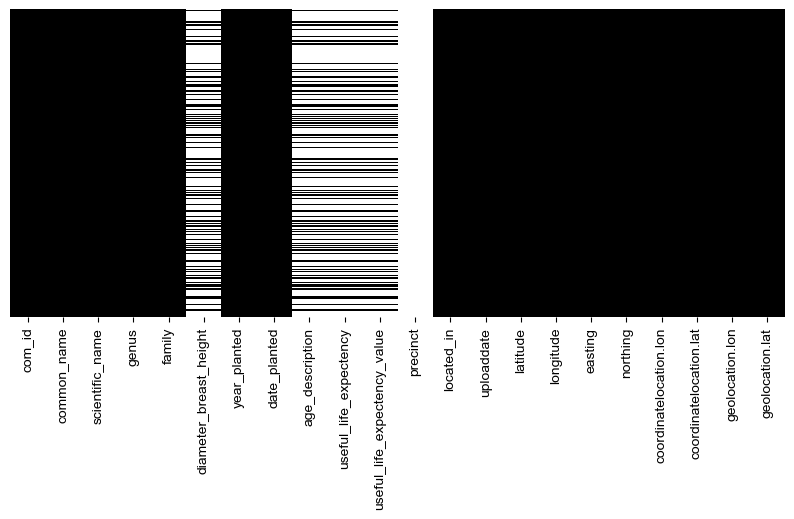

In [28]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set(font_scale=1.2)
sns.heatmap(urban_trees_data.isnull(), yticklabels = False, cbar = False, cmap = 'Greys_r')

plt.show()

In [29]:
urban_trees_data = urban_trees_data.drop(columns = ['precinct', 'uploaddate'])

## crs transformation
tree_geoms = gpd.points_from_xy(x=urban_trees_data.easting,
				y=urban_trees_data.northing,
				crs="EPSG:7855")

urban_trees_data = gpd.GeoDataFrame(urban_trees_data, geometry=tree_geoms)
column_to_drop = ['latitude', 'longitude', 'coordinatelocation.lon', 'coordinatelocation.lat', 'geolocation.lon',
       'geolocation.lat', 'easting', 'northing']
urban_trees_data = urban_trees_data.drop(columns = column_to_drop)
urban_trees_data.head()

com_id           common_name           scientific_name       genus  \
0  1440992         River red gum  Eucalyptus camaldulensis  Eucalyptus   
1  1286119         River red gum  Eucalyptus camaldulensis  Eucalyptus   
2  1439848  European nettle tree          Celtis australis      Celtis   
3  1584631          Swamp Sheoak           Casuarina obesa   Casuarina   
4  1286271         Golden Poplar      Populus x canadensis     Populus   

          family  diameter_breast_height year_planted date_planted  \
0      Myrtaceae                     NaN         2009   2009-12-14   
1      Myrtaceae                    80.0         2008   2008-07-16   
2    Cannabaceae                     4.0         2009   2009-09-08   
3  Casuarinaceae                     NaN         2015   2015-06-18   
4     Salicaceae                    35.0         2008   2008-12-18   

  age_description useful_life_expectency  useful_life_expectency_value  \
0            None                   None                           NaN   
1          Mature            31-60 years                          60.0   
2        Juvenile            31-60 years                          60.0   
3            None                   None                           NaN   
4     Semi-Mature            31-60 years                          60.0   

  located_in                        geometry  
0       Park  POINT (319271.370 5815606.690)  
1       Park  POINT (317353.240 5815470.250)  
2     Street  POINT (316812.460 5814865.650)  
3       Park  POINT (319713.760 5814935.150)  
4     Street  POINT (317538.990 5815415.810)

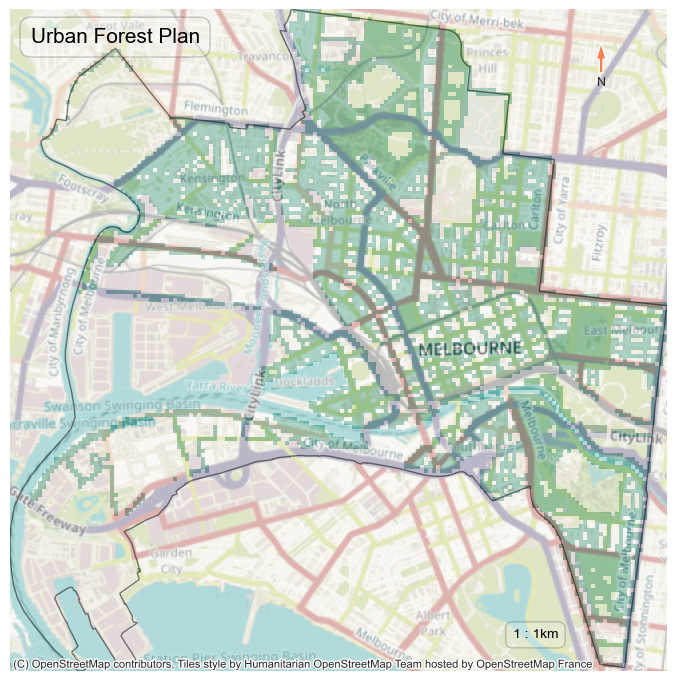

In [30]:
## computing the tree density

minX = municipal_gdf.bounds.minx.values[0]
minY = municipal_gdf.bounds.miny.values[0]
maxX = municipal_gdf.bounds.maxx.values[0]
maxY = municipal_gdf.bounds.maxy.values[0]

# defining the cell size (resolution)
cell_size = 50

height = (maxY - minY)/cell_size
width = (maxX - minX)/cell_size
height = math.ceil(height)
width = math.ceil(width)

lon_bins = np.linspace(minX, maxX, width + 1)
lat_bins = np.linspace(minY, maxY, height + 1)
tree_grid, xedges, yedges = np.histogram2d(urban_trees_data.geometry.x, urban_trees_data.geometry.y, [lon_bins, lat_bins])
tree_grid[tree_grid == 0] = np.nan


## plotting the tree density in the City of Melbourne
fig, ax = plt.subplots(figsize = (7, 9))
ax.axis('off')

# -- Python Citation 1 --
# The following snippet of code aims to add a 'North Arrow'
# And it is impelmented based on a suggestion from Steven in 2019.
# https://stackoverflow.com/questions/58088841/how-to-add-a-north-arrow-on-a-geopandas-map
# ----- ----- ----- ----- -----
x, y, arrow_length = 0.9, 0.95, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='coral', width=2.75, headwidth=7),
            ha='center', va='center', fontsize=9,
            xycoords=ax.transAxes)
# ----- ----- ----- ----- -----

# add the title
ax.annotate(f'Urban Forest Plan', xy=(0.23, 0.9), xycoords='axes fraction', 
            xytext=(0.16, 0.95), textcoords='axes fraction',
            horizontalalignment='center', fontsize=15, color='black',
            bbox=dict(facecolor='white', alpha=0.2, edgecolor='black', boxstyle='round,pad=0.5'))

# add the scale
ax.annotate(f'1 : 1km', xy=(0.23, 0.9), xycoords='axes fraction', 
            xytext=(0.8, 0.05), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.2, edgecolor='black', boxstyle='round,pad=0.5'))

fig.tight_layout()

im = plt.imshow(tree_grid.T, origin = 'lower', cmap='summer', extent = (minX, maxX, minY, maxY))

municipal_gdf.plot(ax=ax, 
                 facecolor = 'none', 
                 edgecolor='black', 
                 linewidth=1, 
                 alpha=0.5)

cx.add_basemap(ax, 
               crs=municipal_gdf.crs,
               alpha = 0.7)

plt.show()

In [31]:
## doing the descriptive analysis on the genus of trees
genus_list = urban_trees_data['genus'].value_counts()

top_genus_name = []
top_genus_num = []
top_genus_percentage = []
counter = 0

for genus_name, num in genus_list.items():
    if counter < 6:
        top_genus_name.append(genus_name)
        top_genus_num.append(num)
        top_genus_percentage.append(round(num / len(urban_trees_data), 2))
    else:
        top_genus_name.append('Other (incl. 165 genuses)')
        top_genus_num.append(len(urban_trees_data) - np.sum(top_genus_num))
        top_genus_percentage.append(round((len(urban_trees_data) - np.sum(top_genus_num[:-2])) / len(urban_trees_data), 2))

        break
    counter += 1

top_genus_name, top_genus_num, top_genus_percentage

(['Eucalyptus',
  'Acacia',
  'Ulmus',
  'Platanus',
  'Corymbia',
  'Allocasuarina',
  'Other (incl. 165 genuses)'],
 [17308, 6557, 5927, 5687, 4664, 3823, 32962],
 [0.22, 0.09, 0.08, 0.07, 0.06, 0.05, 0.48])

In [32]:
## doing the descriptive analysis on the common name of trees
top_common_name_in_genus = []
top_common_name_in_genus_life_expectance = []
top_common_name_in_genus_num = []
top_common_name_in_genus_percentage = []
counter = 0

for genus_name in top_genus_name:
    if counter < 6:
        genus_common_name_list = urban_trees_data[urban_trees_data['genus'] == genus_name]['common_name'].value_counts()
        top_common_name_in_genus.append(genus_common_name_list.keys()[0])
        top_common_name_in_genus_num.append(genus_common_name_list.max())

        top_common_name_in_genus_life_expectance.append(round(urban_trees_data[urban_trees_data['common_name'] == genus_common_name_list.keys()[0]]['useful_life_expectency_value'].mean(), 1))
        
        top_common_name_in_genus_percentage.append(round(genus_common_name_list.max() / top_genus_num[counter], 2))
    else:
        genus_common_name_list = urban_trees_data[~urban_trees_data['genus'].isin(top_genus_name)]['common_name'].value_counts()
        top_common_name_in_genus.append(genus_common_name_list.keys()[0])
        top_common_name_in_genus_num.append(genus_common_name_list.max())
        top_common_name_in_genus_life_expectance.append(round(urban_trees_data[urban_trees_data['common_name'] == genus_common_name_list.keys()[0]]['useful_life_expectency_value'].mean(), 1))
        top_common_name_in_genus_percentage.append(round(genus_common_name_list.max() / top_genus_num[counter], 2))

        break
    counter += 1

top_common_name_in_genus, top_common_name_in_genus_life_expectance, top_common_name_in_genus_num, top_common_name_in_genus_percentage

(['River red gum',
  'Black Wattle',
  'English Elm',
  'London Plane',
  'Spotted Gum',
  'Drooping sheoak',
  'River Sheoak'],
 [55.7, 35.9, 23.4, 20.9, 56.9, 51.2, 49.3],
 [8141, 2660, 2190, 5066, 2965, 3306, 1593],
 [0.47, 0.41, 0.37, 0.89, 0.64, 0.86, 0.05])

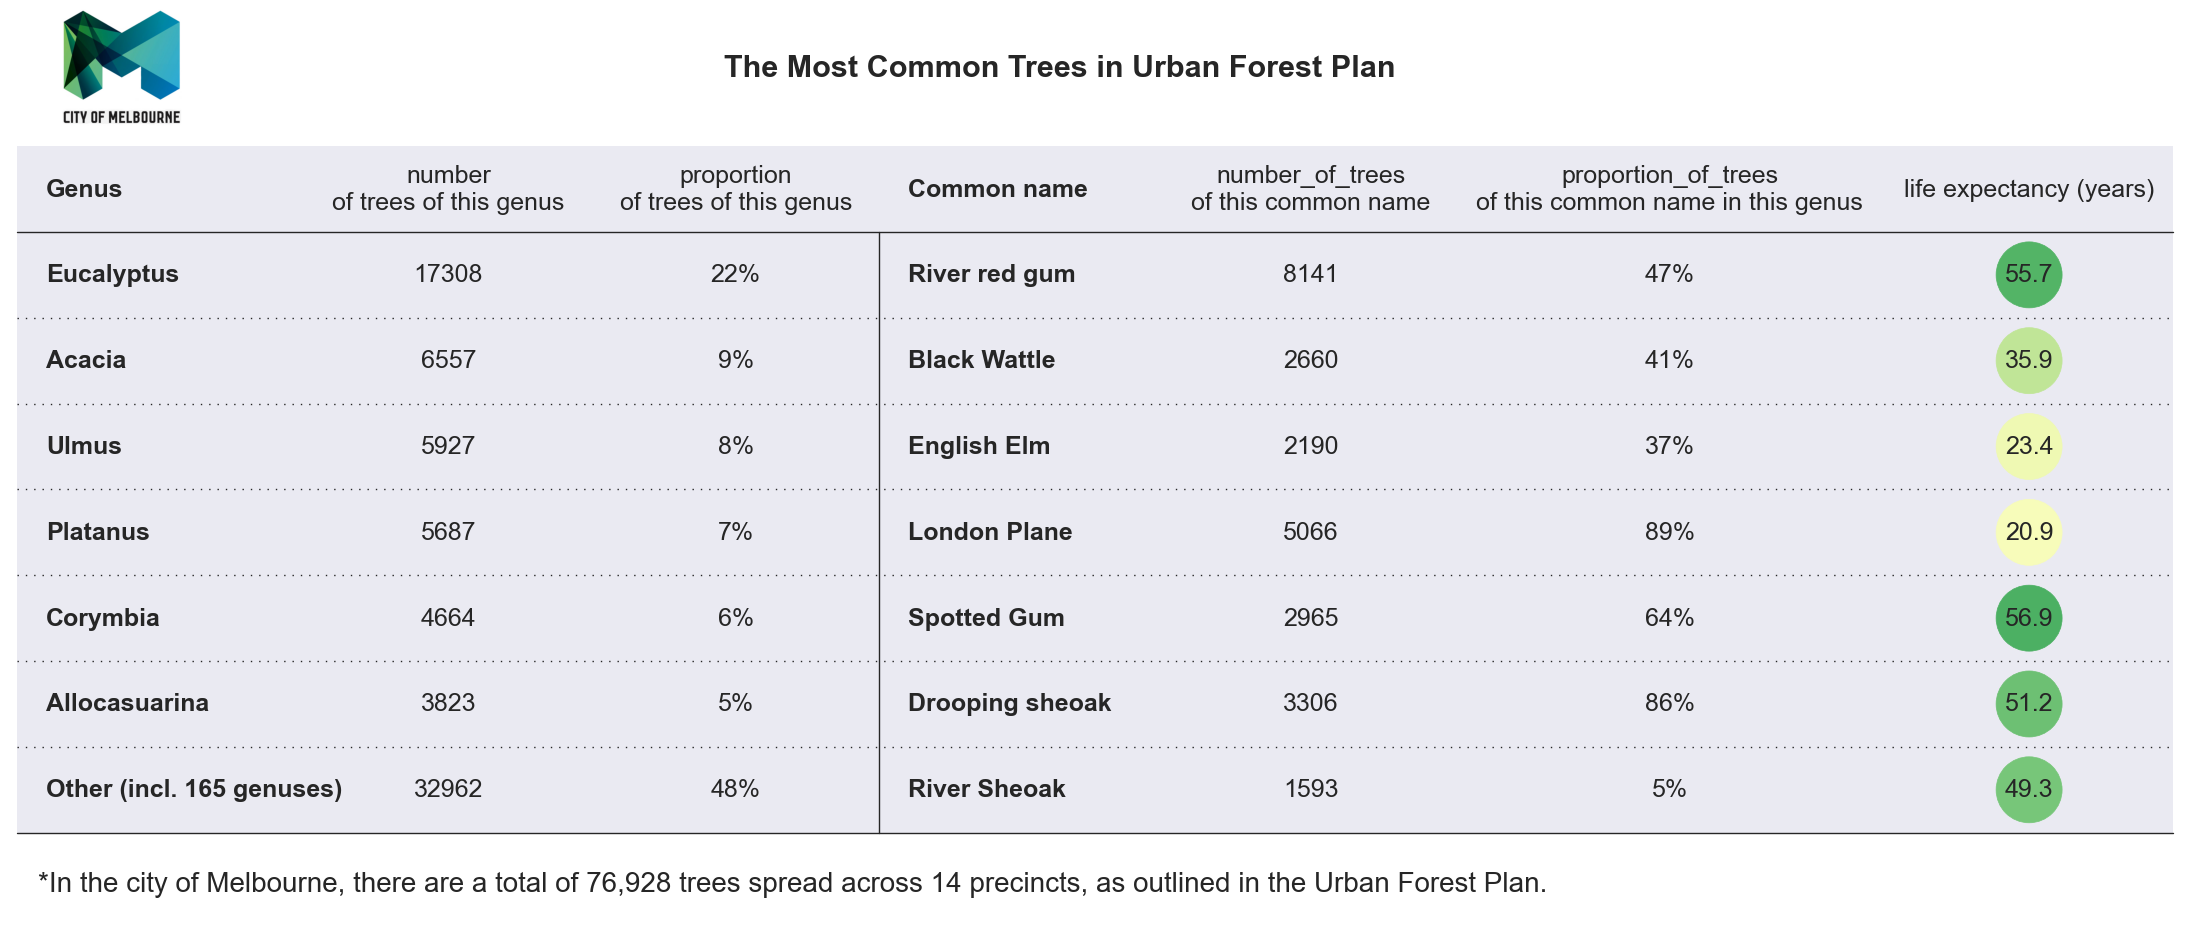

In [33]:
## visulisating the descriptive analysis of trees
fig, ax = plt.subplots(figsize = (28, 9))
fig.suptitle("The Most Common Trees in Urban Forest Plan", fontsize=22, fontweight='bold')
plt.style.use("bmh")
plt.rcParams.update({
                     "axes.facecolor" : "ivory",
                     "axes.edgecolor":  "ivory"
                     })

d = {'Genus': top_genus_name, 'number of trees of this genus': top_genus_num, 'proportion of trees of this genus': top_genus_percentage, 'Common name': top_common_name_in_genus, 'number_of_trees of this common name': top_common_name_in_genus_num, 'proportion_of_trees of this common name in this genus': top_common_name_in_genus_percentage, 'life expectancy (years)': top_common_name_in_genus_life_expectance}

df = pd.DataFrame(data=d)
df = df.set_index("Genus")

col_defs = (
    [
        ColumnDefinition(
            name="Genus",
            textprops={"ha": "left", 'weight': "bold"}
        ),
        ColumnDefinition(
            name="number of trees of this genus",
            title="number of trees of this genus".replace(" ", "\n", 1),
            textprops={"ha": "center"}
        ),
        ColumnDefinition(
            name="proportion of trees of this genus",
            title="proportion of trees of this genus".replace(" ", "\n", 1),
            textprops={"ha": "center"},
            formatter=decimal_to_percent
        ),
    ]
    + [
        ColumnDefinition(
            name="Common name",
            textprops={"ha": "left", 'weight': "bold"},
            border="left",
        ),
        ColumnDefinition(
            name="number_of_trees of this common name",
            title="number_of_trees of this common name".replace(" ", "\n", 1),
            textprops={"ha": "center"}
        ),
        ColumnDefinition(
            name="proportion_of_trees of this common name in this genus",
            title="proportion_of_trees of this common name in this genus".replace(" ", "\n", 1),
            textprops={"ha": "center"},
            formatter=decimal_to_percent,
            width=1.5,
        ),
        ColumnDefinition(
            name="life expectancy (years)",
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.35},
            },
            cmap=normed_cmap(pd.Series(d["life expectancy (years)"]), cmap=matplotlib.cm.YlGn, num_stds=2.5),
        ),
    ]
)

tab = Table(
    df, 
    column_definitions=col_defs,
    row_dividers=True,
    footer_divider=True,
    ax=ax,
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
    textprops={"fontsize": 18},
    )

logo_ax = fig.add_axes(
    [0.1, 0.9, 0.13, 0.13]
)

img = Image.open("melbourne_logo.jpg", 'r')
plt.imshow(img)
plt.axis('off')

metainfo_ax = fig.add_axes(
    [0.15, 0, 0.1, 0.1]
)
plt.axis('off')
plt.text(-0.15, 0.5, '*In the city of Melbourne, there are a total of 76,928 trees spread across 14 precincts, as outlined in the Urban Forest Plan.', fontsize=20)

fig.savefig("tree.png", facecolor=ax.get_facecolor(), dpi=200)

In [34]:
## matching tree data into each suburb
tree_gdf = urban_trees_data
tree_gdf = gpd.sjoin(suburb_gdf, tree_gdf, how = 'left', predicate = 'contains')
tree_gdf = tree_gdf.drop(columns = ['Postcode', 'Area (km^2)', 'geometry', 'index_right'])
tree_gdf = pd.merge(tree_gdf, urban_trees_data, on='com_id', how='left')

tree_gdf = tree_gdf.drop(columns = ['common_name_y', 'scientific_name_y', 'genus_y',
       'family_y', 'diameter_breast_height_y', 'year_planted_y',
       'date_planted_y', 'age_description_y', 'useful_life_expectency_y',
       'useful_life_expectency_value_y', 'located_in_y'])

tree_gdf = tree_gdf[['com_id', 'common_name_x', 'scientific_name_x', 'genus_x', 'family_x', 
       'diameter_breast_height_x', 'year_planted_x', 'date_planted_x', 'age_description_x', 
       'useful_life_expectency_x', 'useful_life_expectency_value_x', 'located_in_x', 'Suburb Name', 'geometry']]

tree_gdf.rename(columns={'common_name_x': 'common_name', 'scientific_name_x': 'scientific_name', 
       'genus_x': 'genus', 'family_x': 'family', 'diameter_breast_height_x': 'diameter_breast_height', 
       'year_planted_x': 'year_planted', 'date_planted_x': 'date_planted', 'age_description_x': 'age_description', 
       'useful_life_expectency_x': 'useful_life_expectency', 'useful_life_expectency_value_x': 'useful_life_expectency_value', 'located_in_x': 'located_in', 'Suburb Name': 'suburb'}, inplace=True)

tree_geoms = tree_gdf['geometry']
tree_gdf = gpd.GeoDataFrame(tree_gdf, geometry=tree_geoms)
tree_gdf.head()

com_id common_name scientific_name  genus    family  \
0  1028242.0         Elm   Ulmus unknown  Ulmus  Ulmaceae   
1  1028243.0         Elm   Ulmus unknown  Ulmus  Ulmaceae   
2  1028244.0         Elm   Ulmus unknown  Ulmus  Ulmaceae   
3  1028250.0         Elm   Ulmus unknown  Ulmus  Ulmaceae   
4  1028251.0         Elm   Ulmus unknown  Ulmus  Ulmaceae   

   diameter_breast_height year_planted date_planted age_description  \
0                    62.0         1900   2000-02-01          Mature   
1                     NaN         1900   2000-02-01            None   
2                    73.0         1900   2000-02-01          Mature   
3                    62.0         1900   2000-02-01          Mature   
4                    60.0         1900   2000-02-01          Mature   

     useful_life_expectency  useful_life_expectency_value located_in  \
0  6-10 years (>50% canopy)                          10.0       Park   
1                      None                           NaN       Park   
2  6-10 years (>50% canopy)                          10.0       Park   
3  6-10 years (>50% canopy)                          10.0       Park   
4               11-20 years                          20.0       Park   

               suburb                        geometry  
0  South Yarra - West  POINT (322525.030 5809438.810)  
1  South Yarra - West  POINT (322516.420 5809440.460)  
2  South Yarra - West  POINT (322506.640 5809441.740)  
3  South Yarra - West  POINT (322432.300 5809452.810)  
4  South Yarra - West  POINT (322422.990 5809453.860)

In [35]:
tree_gdf.crs

<Projected CRS: EPSG:7855>
Name: GDA2020 / MGA zone 55
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Australia - onshore and offshore between 144°E and 150°E.
- bounds: (144.0, -50.89, 150.01, -9.23)
Coordinate Operation:
- name: Map Grid of Australia zone 55
- method: Transverse Mercator
Datum: Geocentric Datum of Australia 2020
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Predicting Tree life expectancy from weather

In [36]:
#Cleaning Weather data.
global_df['current_date_time'] = pd.to_datetime(global_df['current_date_time'], errors='coerce')
    
# Fill missing numeric data with mean or interpolate
numeric_cols = ['latitude', 'longitude', 'temp', 'app_temp', 'dew_point', 'rel_hum', 'delta_t', 'wind_spd', 'wind_gust', 'press_msl', 'low_temp', 'high_temp','rain']
for col in numeric_cols:
    global_df[col] = pd.to_numeric(global_df[col], errors='coerce')
    global_df[col] = global_df[col].fillna(global_df[col].interpolate())  # or use global_df[col].interpolate()


global_df['station'] = global_df['station'].astype(str)
global_df['wind_dir'] = global_df['wind_dir'].astype(str)
global_df['high_wind_gust_dir'] = global_df['high_wind_gust_dir'].astype(str)
global_df['high_wind_gust_time'] = pd.to_datetime(global_df['high_wind_gust_time'], errors='coerce')
    
global_df = global_df[global_df['station'] != 'nan']

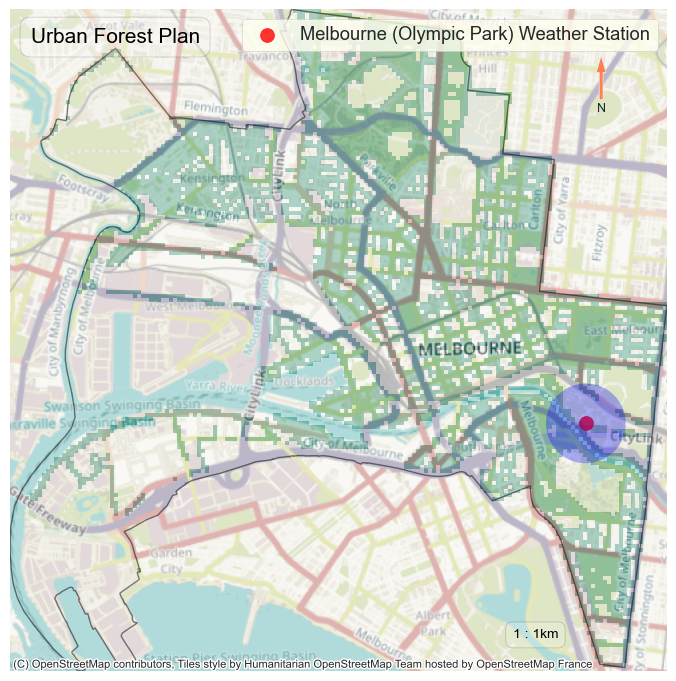

In [39]:
#Analysing Weather Data
fig, ax = plt.subplots(figsize = (7, 9))
ax.axis('off')

# Define the position and length of the north arrow
x, y, arrow_length = 0.9, 0.93, 0.08  # Adjusted y and arrow_length values

# Annotate the north arrow on the plot
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='coral', width=2.75, headwidth=7),
            ha='center', va='center', fontsize=9,
            xycoords=ax.transAxes)

# ----- ----- ----- ----- -----

# add the title
ax.annotate(f'Urban Forest Plan', xy=(0.23, 0.9), xycoords='axes fraction', 
            xytext=(0.16, 0.95), textcoords='axes fraction',
            horizontalalignment='center', fontsize=15, color='black',
            bbox=dict(facecolor='white', alpha=0.2, edgecolor='black', boxstyle='round,pad=0.5'))

# add the scale
ax.annotate(f'1 : 1km', xy=(0.23, 0.9), xycoords='axes fraction', 
            xytext=(0.8, 0.05), textcoords='axes fraction',
            horizontalalignment='center', fontsize=10, color='black',
            bbox=dict(facecolor='white', alpha=0.2, edgecolor='black', boxstyle='round,pad=0.5'))

fig.tight_layout()

im = plt.imshow(tree_grid.T, origin = 'lower', cmap='summer', extent = (minX, maxX, minY, maxY))

municipal_gdf.plot(ax=ax, 
                 facecolor = 'none', 
                 edgecolor='black', 
                 linewidth=1, 
                 alpha=0.5)

# suburb_gdf.plot(ax=ax, 
#                  facecolor = 'none', 
#                  edgecolor='black', 
#                  linewidth=1, 
#                  alpha=0.5)

cx.add_basemap(ax, 
               crs=municipal_gdf.crs,
               alpha = 0.7)

# Define the weather station coordinate
weather_station = {"Melbourne (Olympic Park)": {"lat": -37.822960, "lon": 144.979401}}
weather_station_coords = (144.9830, -37.8220)

# GeoDataFrame for the weather station
weather_gdf = gpd.GeoDataFrame(
    weather_station,
    index=["Melbourne (Olympic Park)"],
    geometry=gpd.points_from_xy(
        [weather_station["Melbourne (Olympic Park)"]["lon"]],
        [weather_station["Melbourne (Olympic Park)"]["lat"]]
    ),
    crs="EPSG:4326"
)

# Transform the weather station data to match the CRS of the map
weather_gdf = weather_gdf.to_crs(municipal_gdf.crs)

# Plot the weather station as a red dot
weather_gdf.plot(ax=ax, color='red', markersize=100, alpha=0.8, label='Melbourne (Olympic Park) Weather Station')

# Adding a blue transparent circle around the weather station
circle = Circle((weather_gdf.geometry.x[0], weather_gdf.geometry.y[0]), radius=500, facecolor='blue', alpha=0.3, edgecolor='none')
ax.add_patch(circle)

# Add a legend for the weather station
plt.legend(loc='upper right')

plt.show()

In [40]:
#Filter the Melbourne Olympic Park data
melbourne_olympic_df = global_df[global_df['station'] == 'Melbourne (Olympic Park)']
display(melbourne_olympic_df.head())

station   current_date_time  latitude  longitude  temp  \
27   Melbourne (Olympic Park) 2024-05-01 10:20:00     -37.8      145.0  13.8   
34   Melbourne (Olympic Park) 2024-05-01 07:50:00     -37.8      145.0  15.4   
40   Melbourne (Olympic Park) 2024-05-01 03:20:00     -37.8      145.0  16.6   
105  Melbourne (Olympic Park) 2024-05-01 11:50:00     -37.8      145.0  13.0   
141  Melbourne (Olympic Park) 2024-05-01 15:50:00     -37.8      145.0  10.2   

     app_temp  dew_point  rel_hum  delta_t wind_dir  ...  press_msl  rain  \
27       12.0        9.3     74.0      2.3        S  ...     1032.1   0.0   
34       12.8        9.5     68.0      3.0      SSE  ...     1031.4   0.0   
40       14.8        7.8     56.0      4.4       SE  ...     1031.5   0.0   
105      10.8        9.3     78.0      1.9      SSE  ...     1032.3   0.0   
141       9.9        8.6     90.0      0.8     CALM  ...     1032.0   0.0   

     low_temp  low_time  high_temp  high_time  high_wind_gust_dir  \
27       13.8     20:20       18.8      15:05                 SSE   
34        8.2     05:44       18.8      15:05                 SSE   
40        8.2     05:44       17.0      13:02                 SSE   
105      12.9     21:49       18.8      15:05                 SSE   
141      10.2     01:50       18.8      15:05                   S   

    high_wind_gust_kmh  high_wind_gust_kts high_wind_gust_time  
27                28.0                15.0 2024-05-16 17:28:00  
34                28.0                15.0 2024-05-16 17:28:00  
40                26.0                14.0 2024-05-16 10:39:00  
105               28.0                15.0 2024-05-16 17:28:00  
141               19.0                10.0 2024-05-16 00:20:00  

[5 rows x 24 columns]

In [41]:
#Tree Information
tree_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 76682 entries, 0 to 76681
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   com_id                        76681 non-null  float64 
 1   common_name                   76660 non-null  object  
 2   scientific_name               76680 non-null  object  
 3   genus                         76680 non-null  object  
 4   family                        76680 non-null  object  
 5   diameter_breast_height        24850 non-null  float64 
 6   year_planted                  76681 non-null  object  
 7   date_planted                  76681 non-null  object  
 8   age_description               24833 non-null  object  
 9   useful_life_expectency        24833 non-null  object  
 10  useful_life_expectency_value  24833 non-null  float64 
 11  located_in                    76679 non-null  object  
 12  suburb                        76682 no

In [42]:
#Melbourne Olympic weather station info
melbourne_olympic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 27 to 9998
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   station              520 non-null    object        
 1   current_date_time    520 non-null    datetime64[ns]
 2   latitude             520 non-null    float64       
 3   longitude            520 non-null    float64       
 4   temp                 520 non-null    float64       
 5   app_temp             520 non-null    float64       
 6   dew_point            520 non-null    float64       
 7   rel_hum              520 non-null    float64       
 8   delta_t              520 non-null    float64       
 9   wind_dir             520 non-null    object        
 10  wind_spd             520 non-null    float64       
 11  wind_gust            520 non-null    float64       
 12  wind_spd_kts         520 non-null    float64       
 13  wind_gust_kts        520 non-null

In [43]:
#Check the variance of the weather data
print(melbourne_olympic_df[['temp', 'rain', 'rel_hum', 'wind_spd']].describe())
melbourne_olympic_filtered = melbourne_olympic_df[['temp', 'rain', 'rel_hum', 'wind_spd']]
display(melbourne_olympic_filtered.head())

             temp        rain     rel_hum    wind_spd
count  520.000000  520.000000  520.000000  520.000000
mean    11.690385    0.025385   85.223077    4.665385
std      2.976495    0.066641   13.208140    4.417468
min      7.000000    0.000000   56.000000    0.000000
25%      9.100000    0.000000   74.000000    0.000000
50%     10.900000    0.000000   89.500000    6.000000
75%     14.125000    0.000000   97.000000    7.000000
max     17.900000    0.200000  100.000000   15.000000


temp  rain  rel_hum  wind_spd
27   13.8   0.0     74.0       9.0
34   15.4   0.0     68.0      13.0
40   16.6   0.0     56.0       7.0
105  13.0   0.0     78.0      11.0
141  10.2   0.0     90.0       0.0

In [58]:
#Combine the data

# Filter the last entry of each day from the weather data
melbourne_olympic_df['date'] = melbourne_olympic_df['current_date_time'].dt.date
daily_weather = melbourne_olympic_df.groupby('date').apply(lambda x: x.iloc[-1]).reset_index(drop=True)

# Use the latest weather data available
latest_weather = daily_weather.iloc[-1]

# Convert the latest weather data to a DataFrame and replicate it
latest_weather_df = pd.DataFrame([latest_weather] * len(tree_gdf), columns=latest_weather.index)

# Reset index for the latest weather data DataFrame
latest_weather_df.reset_index(drop=True, inplace=True)

# Take a subset of tree data for testing
# tree_subset = tree_gdf.sample(n=20000, random_state=42).reset_index(drop=True)

# Concatenate the tree data with the replicated latest weather data
combined_data = pd.concat([tree_gdf, latest_weather_df.loc[:len(tree_gdf)-1]], axis=1)

# Reset index for combined data
combined_data.reset_index(drop=True, inplace=True)

# Display the prepared data
display(combined_data.head(110))


com_id   common_name        scientific_name     genus       family  \
0    1028242.0           Elm          Ulmus unknown     Ulmus     Ulmaceae   
1    1028243.0           Elm          Ulmus unknown     Ulmus     Ulmaceae   
2    1028244.0           Elm          Ulmus unknown     Ulmus     Ulmaceae   
3    1028250.0           Elm          Ulmus unknown     Ulmus     Ulmaceae   
4    1028251.0           Elm          Ulmus unknown     Ulmus     Ulmaceae   
..         ...           ...                    ...       ...          ...   
105  1028335.0  London Plane  Platanus x acerifolia  Platanus  Platanaceae   
106  1035053.0   English Elm          Ulmus procera     Ulmus     Ulmaceae   
107  1028334.0  London Plane  Platanus x acerifolia  Platanus  Platanaceae   
108  1035054.0   English Elm          Ulmus procera     Ulmus     Ulmaceae   
109  1028333.0  London Plane  Platanus x acerifolia  Platanus  Platanaceae   

     diameter_breast_height year_planted date_planted age_description  \
0                      62.0         1900   2000-02-01          Mature   
1                       NaN         1900   2000-02-01            None   
2                      73.0         1900   2000-02-01          Mature   
3                      62.0         1900   2000-02-01          Mature   
4                      60.0         1900   2000-02-01          Mature   
..                      ...          ...          ...             ...   
105                    63.0         1900   2000-01-01          Mature   
106                    88.0         1900   2000-01-01          Mature   
107                    54.0         1997   1997-12-02          Mature   
108                    88.0         1900   2000-01-01          Mature   
109                    52.0         1997   1997-12-02          Mature   

       useful_life_expectency  ...  rain low_temp low_time high_temp  \
0    6-10 years (>50% canopy)  ...   0.0     11.5    00:50      18.3   
1                        None  ...   0.0     11.5    00:50      18.3   
2    6-10 years (>50% canopy)  ...   0.0     11.5    00:50      18.3   
3    6-10 years (>50% canopy)  ...   0.0     11.5    00:50      18.3   
4                 11-20 years  ...   0.0     11.5    00:50      18.3   
..                        ...  ...   ...      ...      ...       ...   
105               11-20 years  ...   0.0     11.5    00:50      18.3   
106               11-20 years  ...   0.0     11.5    00:50      18.3   
107  6-10 years (>50% canopy)  ...   0.0     11.5    00:50      18.3   
108               11-20 years  ...   0.0     11.5    00:50      18.3   
109  6-10 years (>50% canopy)  ...   0.0     11.5    00:50      18.3   

    high_time high_wind_gust_dir  high_wind_gust_kmh  high_wind_gust_kts  \
0       16:42                SSE                 9.0                 5.0   
1       16:42                SSE                 9.0                 5.0   
2       16:42                SSE                 9.0                 5.0   
3       16:42                SSE                 9.0                 5.0   
4       16:42                SSE                 9.0                 5.0   
..        ...                ...                 ...                 ...   
105     16:42                SSE                 9.0                 5.0   
106     16:42                SSE                 9.0                 5.0   
107     16:42                SSE                 9.0                 5.0   
108     16:42                SSE                 9.0                 5.0   
109     16:42                SSE                 9.0                 5.0   

     high_wind_gust_time        date  
0    2024-05-16 00:08:00  2024-05-05  
1    2024-05-16 00:08:00  2024-05-05  
2    2024-05-16 00:08:00  2024-05-05  
3    2024-05-16 00:08:00  2024-05-05  
4    2024-05-16 00:08:00  2024-05-05  
..                   ...         ...  
105  2024-05-16 00:08:00  2024-05-05  
106  2024-05-16 00:08:00  2024-05-05  
107  2024-05-16 00:08:00  2024-05-05  
108  2024-05-16 00:08:00  

In [71]:
#Predictive Modelling

# Select relevant columns
combined_data = combined_data[['temp', 'rain', 'rel_hum', 'wind_spd', 'year_planted', 'useful_life_expectency_value']]

# Fill NaN values with the mean of each column
numeric_columns = combined_data.select_dtypes(include=[np.number]).columns
combined_data[numeric_columns] = combined_data[numeric_columns].fillna(combined_data[numeric_columns].mean())

combined_data['year_planted'].fillna(combined_data['year_planted'].median(), inplace=True)

# Ensure no NaN values are present
# print(combined_data.isna().sum())

# Prepare the data for the model
X = combined_data[['temp', 'rain', 'rel_hum', 'wind_spd', 'year_planted']]
y = combined_data['useful_life_expectency_value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# print(f'Train MSE: {train_mse}, Train R2: {train_r2}')
# print(f'Test MSE: {test_mse}, Test R2: {test_r2}')

# Define a function to predict life expectancy based on weather input with validation
def predict_life_expectancy(weather_input):
    # Validate the input data
    temp, rain, rel_hum, wind_spd, year_planted = weather_input
    if temp < -50 or temp > 50:
        return "Invalid temperature value"
    if rain < 0:
        return "Invalid rainfall value"
    if rel_hum < 0 or rel_hum > 100:
        return "Invalid relative humidity value"
    if wind_spd < 0:
        return "Invalid wind speed value"
    if year_planted < 0 or year_planted > 2024:  # Assuming year_planted should be in a reasonable range
        return "Invalid year planted value"
    
    predicted_life_expectancy = model.predict([weather_input])
    return max(predicted_life_expectancy[0], 0)  # Ensure the prediction is non-negative

def interactive_prediction():
    while True:
        try:
            temp = float(input("Enter temperature (in °C): "))
            rain = float(input("Enter rainfall (in mm): "))
            rel_hum = float(input("Enter relative humidity (in %): "))
            wind_spd = float(input("Enter wind speed (in km/h): "))
            year_planted = int(input("Enter year planted (YYYY): "))
            
            weather_input = [temp, rain, rel_hum, wind_spd, year_planted]
            predicted_life_expectancy = predict_life_expectancy(weather_input)
            print(f'Predicted Tree Life Expectancy for:')
            print(f'Temperature: {temp}°C, Rainfall: {rain}mm, Relative Humidity: {rel_hum}%, Wind Speed: {wind_spd} km/h, Year Planted: {year_planted}')
            print(f'Predicted Life Expectancy: {predicted_life_expectancy:.2f} years\n')
            
            cont = input("Do you want to enter another set of values? (yes/no): ")
            if cont.lower() != 'yes':
                break
        except ValueError:
            print("Invalid input. Please enter numerical values.")

# Call the interactive prediction function
interactive_prediction()


Predicted Tree Life Expectancy for:
Temperature: 20.0°C, Rainfall: 2.0mm, Relative Humidity: 20.0%, Wind Speed: 200.0 km/h, Year Planted: 1997
Predicted Life Expectancy: 26.26 years



Data Cleaning - Population Data

In [54]:
population_data.head()

id                sa2_name_2016  \
0  abs_regional_population_sa2_2001_2021.699              North Melbourne   
1  abs_regional_population_sa2_2001_2021.728                Hawthorn East   
2  abs_regional_population_sa2_2001_2021.700                    Parkville   
3  abs_regional_population_sa2_2001_2021.701           South Yarra - West   
4  abs_regional_population_sa2_2001_2021.748  Cheltenham - Highett (West)   

     gccsa_name_2016 state_name_2016  erp_2021   sa3_name_2016  area_km2  \
0  Greater Melbourne        Victoria     26337  Melbourne City    3.2492   
1  Greater Melbourne        Victoria     16724      Boroondara    3.8240   
2  Greater Melbourne        Victoria      7964  Melbourne City    4.0492   
3  Greater Melbourne        Victoria      6471  Melbourne City    1.5027   
4  Greater Melbourne        Victoria     12534         Bayside    5.3198   

   state_code_2016  erp_2011            sa4_name_2016  \
0                2     16361        Melbourne - Inner   
1                2     14417   Melbourne - Inner East   
2                2      6551        Melbourne - Inner   
3                2      6426        Melbourne - Inner   
4                2     10544  Melbourne - Inner South   

   pop_density_2021_people_per_km2 sa2_maincode_2016  sa4_code_2016  \
0                      8105.687500         206041123            206   
1                      4373.431152         207011152            207   
2                      1966.808350         206041124            206   
3                      4306.249023         206041125            206   
4                      2356.103516         208011171            208   

   primaryindex  erp_2001 gccsa_code_2016  sa3_code_2016 geometry.type  \
0           699     11639           2GMEL          20604  MultiPolygon   
1           728     12912           2GMEL          20701  MultiPolygon   
2           700      5332           2GMEL          20604  MultiPolygon   
3           701      5317           2GMEL          20604  MultiPolygon   
4           748      9657           2GMEL          20801  MultiPolygon   

                                geometry.coordinates  
0  [[[[144.9595040370001, -37.806293240999935], [...  
1  [[[[145.05935646700004, -37.817372390999935], ...  
2  [[[[144.9641102280001, -37.79273024399998], [1...  
3  [[[[144.98784552100005, -37.83063332099994], [...  
4  [[[[145.03930417000004, -37.94473898999996], [...

In [55]:
population_data.columns

Index(['id', 'sa2_name_2016', 'gccsa_name_2016', 'state_name_2016', 'erp_2021',
       'sa3_name_2016', 'area_km2', 'state_code_2016', 'erp_2011',
       'sa4_name_2016', 'pop_density_2021_people_per_km2', 'sa2_maincode_2016',
       'sa4_code_2016', 'primaryindex', 'erp_2001', 'gccsa_code_2016',
       'sa3_code_2016', 'geometry.type', 'geometry.coordinates'],
      dtype='object')

In [56]:
pop_data = population_data.drop(columns=['id', 'gccsa_name_2016', 'state_name_2016', 
                                        'state_code_2016', 'erp_2011', 'sa4_name_2016',
                                        'sa2_maincode_2016', 'sa4_code_2016', 'primaryindex', 'erp_2001',
                                        'gccsa_code_2016', 'sa3_code_2016', 'geometry.type', 'geometry.coordinates'])

pop_data = pop_data[(pop_data['sa3_name_2016'] == 'Melbourne City') | (pop_data['sa2_name_2016'] == 'Port Melbourne') | (pop_data['sa2_name_2016'] == 'Carlton North - Princes Hill')]
pop_data.rename(columns={'sa2_name_2016': 'precinct', 'erp_2021': 'population', 'sa3_name_2016': 'sa3', 'area_km2':'area (km^2)', 'pop_density_2021_people_per_km2': 'density'}, inplace=True)

## adding South Wharf precinct into the census dataframe
## and modify the population number of West Melbourne (initially, only 3 people)
## both manipulations are based on ABS 2021 census data
## source from: https://abs.gov.au/census/find-census-data/quickstats/2021/SAL22313
## https://www.abs.gov.au/census/find-census-data/quickstats/2021/SAL22757
south_wharf_df = pd.DataFrame({'precinct': ['South Wharf'], 'population': [71], 'sa3': ['Melbourne City'], 'area (km^2)': ['0.26'], 'density': ['273']})
pop_data = pd.concat([pop_data, south_wharf_df], ignore_index=True)

pop_data.at[10, 'population'] = 8025
pop_data.at[10, 'density'] = 1294.52

In [57]:
pop_data

precinct  population             sa3 area (km^2)  \
0                North Melbourne       26337  Melbourne City      3.2492   
1                      Parkville        7964  Melbourne City      4.0492   
2             South Yarra - West        6471  Melbourne City      1.5027   
3                      Southbank       26354  Melbourne City      3.0743   
4              Kensington (Vic.)       11836  Melbourne City       2.147   
5                      Melbourne       47192  Melbourne City       2.369   
6                        Carlton       23070  Melbourne City      1.8185   
7                      Docklands       14821  Melbourne City       2.444   
8                 East Melbourne        5803  Melbourne City      2.8998   
9          Flemington Racecourse          91  Melbourne City      1.7093   
10                West Melbourne        8025  Melbourne City      6.1992   
11                Port Melbourne       17632    Port Phillip      2.7894   
12  Carlton North - Princes Hill        8828           Yarra      2.3042   
13                   South Wharf          71  Melbourne City        0.26   

         density  
0      8105.6875  
1     1966.80835  
2    4306.249023  
3    8572.357422  
4    5512.808594  
5   19920.640625  
6   12686.280273  
7     6064.23877  
8    2001.172485  
9      53.238201  
10       1294.52  
11   6321.072754  
12   3831.264648  
13           273

In [58]:
suburb_gdf

Suburb Name  Postcode  Area (km^2)  \
0             South Yarra - West      3141         1.06   
1                 East Melbourne      3002         1.91   
2                 Port Melbourne      3207         5.47   
3                      Docklands      3008         2.86   
4                North Melbourne      3051         2.41   
5                      Parkville      3052         4.05   
6                      Melbourne      3000         5.15   
7                 West Melbourne      3003         6.78   
8          Flemington Racecourse      3031         1.70   
9              Kensington (Vic.)      3031         2.13   
10                       Carlton      3053         1.75   
11  Carlton North - Princes Hill      3054         0.91   
12                   South Wharf      3005         0.26   
13                     Southbank      3006         1.31   

                                             geometry  
0   POLYGON ((322619.656 5809407.034, 322294.651 5...  
1   POLYGON ((321860.347 5813528.984, 323177.833 5...  
2   POLYGON ((316056.169 5812009.129, 316447.801 5...  
3   POLYGON ((319719.658 5812826.857, 319761.152 5...  
4   POLYGON ((320178.277 5814208.520, 320273.382 5...  
5   POLYGON ((318612.614 5815797.521, 318603.428 5...  
6   POLYGON ((322336.207 5808883.294, 322258.102 5...  
7   POLYGON ((316663.769 5812156.304, 316447.801 5...  
8   POLYGON ((317097.521 5815560.242, 317106.417 5...  
9   POLYGON ((316853.535 5814487.189, 316713.200 5...  
10  POLYGON ((321639.944 5814098.047, 321580.474 5...  
11  POLYGON ((320370.756 5815419.148, 320358.503 5...  
12  POLYGON ((319973.211 5811460.455, 319939.465 5...  
13  POLYGON ((319939.465 5811432.231, 319973.211 5...

In [49]:
# suburb_gdf[suburb_gdf['Suburb Name'] == 'Carlton'].plot()

In [64]:
# tree_gdf[tree_gdf['suburb'] == 'Carlton'].plot()

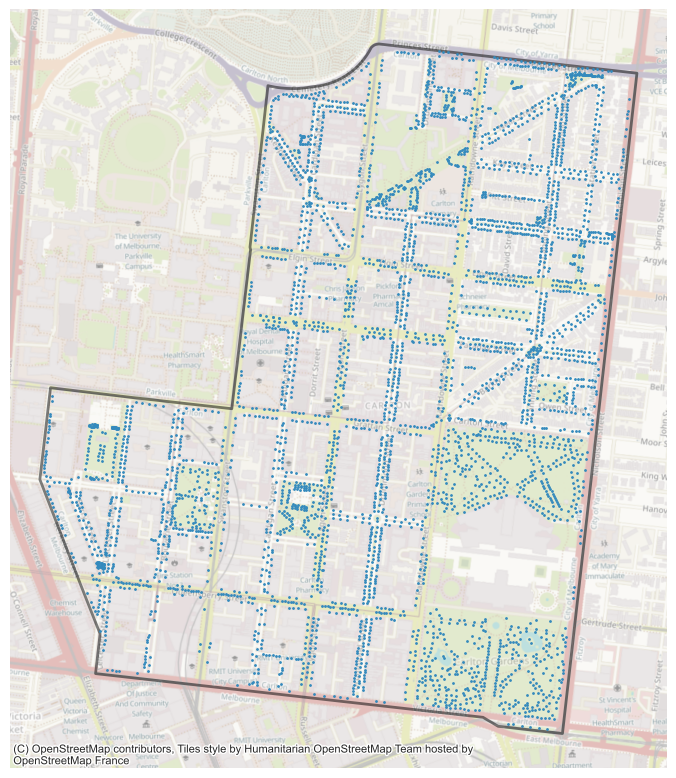

In [71]:
## Plotting suburb boundaries to the City of Melbourne's map
fig, ax = plt.subplots(figsize=(7, 9))
ax.axis('off')

suburb_gdf[suburb_gdf['Suburb Name'] == 'Carlton'].plot(ax=ax, 
                 facecolor = 'none', 
                 edgecolor='black', 
                 linewidth=2, 
                 alpha=0.5)

# suburb_gdf.plot(ax=ax, 
#                  facecolor = 'none', 
#                  edgecolor='black', 
#                  linewidth=2, 
#                  alpha=0.5)

tree_gdf[tree_gdf['suburb'] == 'Carlton'].plot(ax = ax, linewidth=1, markersize=1)

cx.add_basemap(ax, crs=municipal_gdf.crs, alpha=0.6)

fig.tight_layout()